# Projekt Sieci neuronowe

#### Emilia Gawenda, Marlena Kozieł, Magdalena Leśniowska

Naszym celem jest zbudowanie modelu opartego o architekturę sieci konwolucyjnej, który będzie identyfikował klasy ubrań ze zbioru fashion MNIST.

Importujemy zbiór danych.

In [ ]:
import torchvision
from torchvision import transforms
image_path = './'
transform = transforms.Compose([transforms.ToTensor()])

fashion_mnist_dataset = torchvision.datasets.FashionMNIST(root=image_path,
                                           train=True,
                                           transform=transform,
                                           download=True)

100%|██████████| 26421880/26421880 [00:02<00:00, 11618577.56it/s]


Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 211283.27it/s]


Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:02<00:00, 2192177.63it/s]


Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 22800714.88it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



Tworzymy zbiory: uczący, walidacyjny i testowy.

In [ ]:
import torch
import matplotlib.pyplot as plt

from torch.utils.data import Subset

fashion_mnist_valid_dataset = Subset(fashion_mnist_dataset, torch.arange(10000))
fashion_mnist_train_dataset = Subset(fashion_mnist_dataset, torch.arange(10000, len(fashion_mnist_dataset)))
fashion_mnist_test_dataset = torchvision.datasets.FashionMNIST(root=image_path,
                                           train=False,
                                           transform=transform,
                                           download=False)

Zobaczmy, jak wyglądają przykłady ze zbioru.

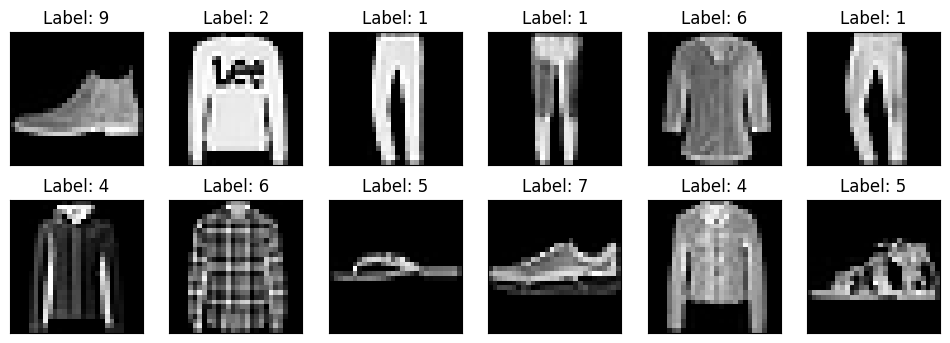

In [ ]:
fig = plt.figure(figsize=(12, 4))
for i in range(12):
    ax = fig.add_subplot(2, 6, i+1)
    ax.set_xticks([])
    ax.set_yticks([])
    img, label = fashion_mnist_test_dataset[i]
    ax.imshow(img.squeeze(), cmap='gray')
    ax.set_title(f"Label: {label}")

plt.show()

Augumentacja - robimy symetrie pionowe

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.RandomHorizontalFlip()
])

In [ ]:
from torch.utils.data import DataLoader

fashion_mnist_train_dataset = torchvision.datasets.FashionMNIST(image_path,
                                                train = True,
                                                download = False,
                                                transform = transform
)

Tworzymy data loadery.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 64
torch.manual_seed(1)
train_dl = DataLoader(fashion_mnist_train_dataset, batch_size, shuffle=True)
valid_dl = DataLoader(fashion_mnist_valid_dataset, batch_size, shuffle=False)
test_dl = DataLoader(fashion_mnist_test_dataset, batch_size, shuffle=False)


#### Architektura 1

Dwukrotnie robimy warstwę konwolucyjną z funkcją aktywacji ReLU, dropout z prawdopodobieństwem 0.5 (by zmniejszyć overfitting), max pooling.

In [ ]:
import torch.nn as nn

model_1 = nn.Sequential()
model_1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2))
model_1.add_module('ReLU1', nn.ReLU())
model_1.add_module('dropout1', nn.Dropout(p = 0.5))
model_1.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_1.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_1.add_module('ReLU2', nn.ReLU())
model_1.add_module('dropout2', nn.Dropout(p = 0.5))
model_1.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_1.add_module('flatten', nn.Flatten())

In [ ]:
x = torch.ones((1, 1, 28, 28))
model_1(x).shape

torch.Size([1, 6272])

Warstwa liniowa

In [ ]:
model_1.add_module('fc1', nn.Linear(6272, 1024))
model_1.add_module('ReLU3', nn.ReLU())
model_1.add_module('fc2', nn.Linear(1024, 10))

Jeśli jest to możliwe, robimy na GPU.

In [ ]:
device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device('cpu')
print(device)

cuda:0


In [ ]:
model_1 = model_1.to(device)

Ustawiamy ręcznie weight_decay by zwiększyć regularyzację modelu i zmniejszyć overfitting.

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_1.parameters(), weight_decay = 0.05, lr=0.001)

In [ ]:
def train(model, num_epochs, train_dl, valid_dl):
    loss_hist_train = [0] * num_epochs
    accuracy_hist_train = [0] * num_epochs
    loss_hist_valid = [0] * num_epochs
    accuracy_hist_valid = [0] * num_epochs


    for epoch in range(num_epochs):
        model.train()
        for x_batch, y_batch in train_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)
            loss = loss_fn(pred, y_batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            loss_hist_train[epoch] += loss.item()*y_batch.size(0)
            is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
            accuracy_hist_train[epoch] += is_correct.sum().cpu()

        loss_hist_train[epoch] /= len(train_dl.dataset)
        accuracy_hist_train[epoch] /= len(train_dl.dataset)

        model.eval()
        with torch.no_grad():
            for x_batch, y_batch in valid_dl:
                x_batch = x_batch.to(device)
                y_batch = y_batch.to(device)
                pred = model(x_batch)
                loss = loss_fn(pred, y_batch)
                loss_hist_valid[epoch] += loss.item()*y_batch.size(0)
                is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
                accuracy_hist_valid[epoch] += is_correct.sum().cpu()

        loss_hist_valid[epoch] /= len(valid_dl.dataset)
        accuracy_hist_valid[epoch] /= len(valid_dl.dataset)

        print(f'Epoch {epoch+1} accuracy: {accuracy_hist_train[epoch]:.4f} val_accuracy: {accuracy_hist_valid[epoch]:.4f}')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model_1, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8364 val_accuracy: 0.8978
Epoch 2 accuracy: 0.8888 val_accuracy: 0.9104
Epoch 3 accuracy: 0.9002 val_accuracy: 0.9213
Epoch 4 accuracy: 0.9087 val_accuracy: 0.9291
Epoch 5 accuracy: 0.9130 val_accuracy: 0.9206
Epoch 6 accuracy: 0.9189 val_accuracy: 0.9371
Epoch 7 accuracy: 0.9214 val_accuracy: 0.9406
Epoch 8 accuracy: 0.9249 val_accuracy: 0.9456
Epoch 9 accuracy: 0.9293 val_accuracy: 0.9471
Epoch 10 accuracy: 0.9315 val_accuracy: 0.9481
Epoch 11 accuracy: 0.9343 val_accuracy: 0.9491
Epoch 12 accuracy: 0.9356 val_accuracy: 0.9578
Epoch 13 accuracy: 0.9387 val_accuracy: 0.9581
Epoch 14 accuracy: 0.9396 val_accuracy: 0.9613
Epoch 15 accuracy: 0.9408 val_accuracy: 0.9624
Epoch 16 accuracy: 0.9446 val_accuracy: 0.9620
Epoch 17 accuracy: 0.9430 val_accuracy: 0.9578
Epoch 18 accuracy: 0.9462 val_accuracy: 0.9607
Epoch 19 accuracy: 0.9473 val_accuracy: 0.9658
Epoch 20 accuracy: 0.9483 val_accuracy: 0.9629


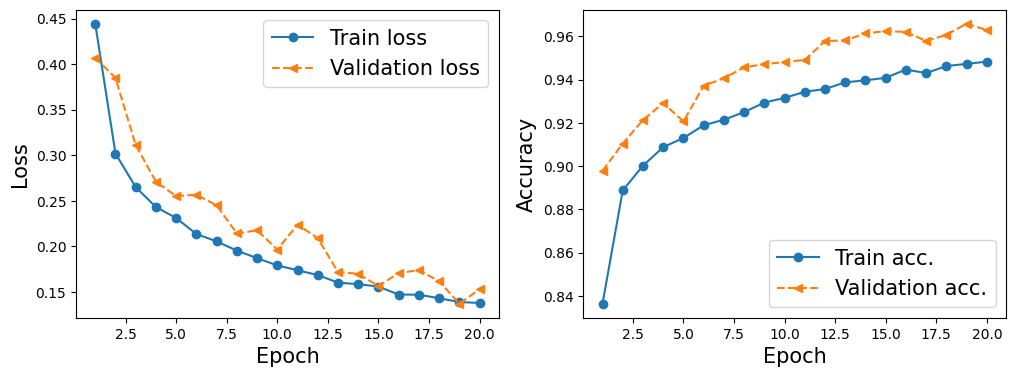

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
def test_model(model, test_dl):
    correct_count = 0

    model.eval()
    with torch.no_grad():
        for x_batch, y_batch in valid_dl:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            pred = model(x_batch)

            is_correct = (torch.argmax(pred, dim=1) == y_batch)
            correct_count += is_correct.sum()

    return correct_count / len(test_dl.dataset)

In [ ]:
test_model(model_1, test_dl).item()

0.9628999829292297

Udało się uzyskać przyzwoity wynik bez overfittingu.

Wypróbujmy ten sam model, ale z learning rate = 0.0005.

In [ ]:
import torch.nn as nn

model_1 = nn.Sequential()
model_1.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=64, kernel_size=5, padding=2))
model_1.add_module('ReLU1', nn.ReLU())
model_1.add_module('dropout1', nn.Dropout(p = 0.5))
model_1.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_1.add_module('conv2', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_1.add_module('ReLU2', nn.ReLU())
model_1.add_module('dropout2', nn.Dropout(p = 0.5))
model_1.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_1.add_module('flatten', nn.Flatten())
model_1.add_module('fc1', nn.Linear(6272, 1024))
model_1.add_module('ReLU3', nn.ReLU())
model_1.add_module('fc2', nn.Linear(1024, 10))


In [ ]:
model_1 = model_1.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_1.parameters(), weight_decay = 0.05, lr=0.0005)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist = train(model_1, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8388 val_accuracy: 0.8957
Epoch 2 accuracy: 0.8911 val_accuracy: 0.9137
Epoch 3 accuracy: 0.9048 val_accuracy: 0.9255
Epoch 4 accuracy: 0.9135 val_accuracy: 0.9319
Epoch 5 accuracy: 0.9191 val_accuracy: 0.9252
Epoch 6 accuracy: 0.9250 val_accuracy: 0.9421
Epoch 7 accuracy: 0.9285 val_accuracy: 0.9469
Epoch 8 accuracy: 0.9342 val_accuracy: 0.9546
Epoch 9 accuracy: 0.9373 val_accuracy: 0.9544
Epoch 10 accuracy: 0.9406 val_accuracy: 0.9582
Epoch 11 accuracy: 0.9446 val_accuracy: 0.9596
Epoch 12 accuracy: 0.9483 val_accuracy: 0.9643
Epoch 13 accuracy: 0.9503 val_accuracy: 0.9671
Epoch 14 accuracy: 0.9545 val_accuracy: 0.9699
Epoch 15 accuracy: 0.9556 val_accuracy: 0.9702
Epoch 16 accuracy: 0.9576 val_accuracy: 0.9740
Epoch 17 accuracy: 0.9590 val_accuracy: 0.9732
Epoch 18 accuracy: 0.9604 val_accuracy: 0.9782
Epoch 19 accuracy: 0.9629 val_accuracy: 0.9755
Epoch 20 accuracy: 0.9623 val_accuracy: 0.9694


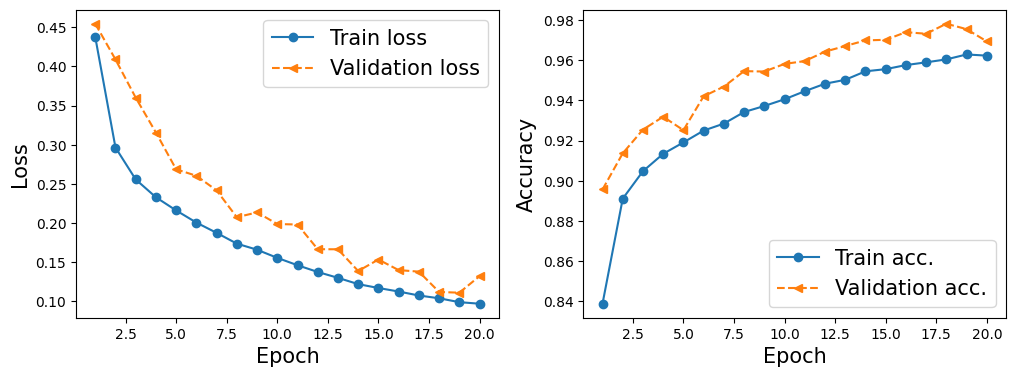

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist[0], '-o', label='Train loss')
ax.plot(x_arr, hist[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist[2], '-o', label='Train acc.')
ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_model(model_1, test_dl).item()

0.9693999886512756

Model ze zmniejszonym learning rate'm działa lepiej.

#### Architektura 2

Zagęścimy sieć dodając podwójne warstwy konwolucyjne. Zmniejszamy prawdopodobieństwo w dropout'cie.

In [ ]:
import torch.nn as nn

model_2 = nn.Sequential()
model_2.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model_2.add_module('ReLU1', nn.ReLU())
model_2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model_2.add_module('ReLU2', nn.ReLU())
model_2.add_module('dropout1', nn.Dropout(p = 0.3))
model_2.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_2.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_2.add_module('ReLU3', nn.ReLU())
model_2.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model_2.add_module('ReLU4', nn.ReLU())
model_2.add_module('dropout2', nn.Dropout(p=0.3))
model_2.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_2.add_module('flatten', nn.Flatten())

In [ ]:
x = torch.ones((1, 1, 28, 28))
model_2(x).shape

torch.Size([1, 12544])

In [ ]:
model_2.add_module('fc1', nn.Linear(12544, 1024))
model_2.add_module('ReLU5', nn.ReLU())
model_2.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
model_2 = model_2.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), weight_decay = 0.05, lr=0.001)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_2 = train(model_2, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8354 val_accuracy: 0.8914
Epoch 2 accuracy: 0.9001 val_accuracy: 0.9172
Epoch 3 accuracy: 0.9160 val_accuracy: 0.9255
Epoch 4 accuracy: 0.9250 val_accuracy: 0.9382
Epoch 5 accuracy: 0.9320 val_accuracy: 0.9362
Epoch 6 accuracy: 0.9379 val_accuracy: 0.9475
Epoch 7 accuracy: 0.9413 val_accuracy: 0.9509
Epoch 8 accuracy: 0.9464 val_accuracy: 0.9562
Epoch 9 accuracy: 0.9501 val_accuracy: 0.9619
Epoch 10 accuracy: 0.9538 val_accuracy: 0.9686
Epoch 11 accuracy: 0.9551 val_accuracy: 0.9694
Epoch 12 accuracy: 0.9600 val_accuracy: 0.9711
Epoch 13 accuracy: 0.9620 val_accuracy: 0.9753
Epoch 14 accuracy: 0.9646 val_accuracy: 0.9748
Epoch 15 accuracy: 0.9660 val_accuracy: 0.9791
Epoch 16 accuracy: 0.9676 val_accuracy: 0.9798
Epoch 17 accuracy: 0.9693 val_accuracy: 0.9837
Epoch 18 accuracy: 0.9704 val_accuracy: 0.9797
Epoch 19 accuracy: 0.9717 val_accuracy: 0.9803
Epoch 20 accuracy: 0.9724 val_accuracy: 0.9864


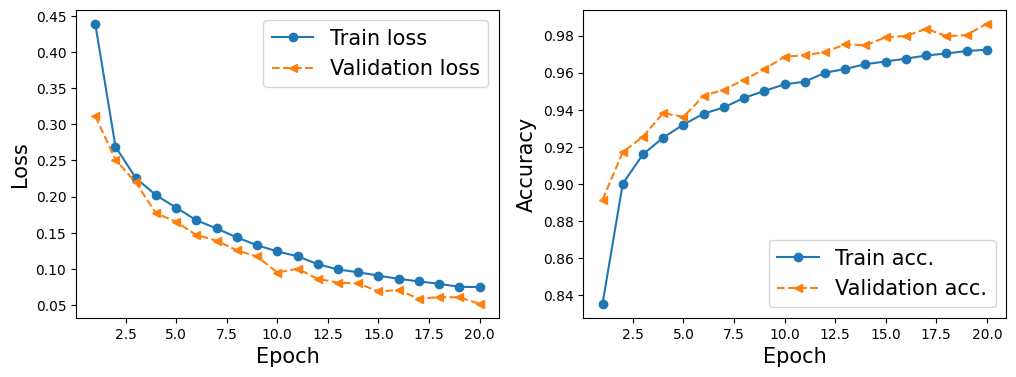

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_2[0], '-o', label='Train loss')
ax.plot(x_arr, hist_2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_2[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_model(model_2, test_dl).item()

0.9863999485969543

Uzyskujemy bardzo dobry wynik. Może uda się go poprawić zmianą learning rate'u.

In [ ]:
import torch.nn as nn

model_2 = nn.Sequential()
model_2.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model_2.add_module('ReLU1', nn.ReLU())
model_2.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model_2.add_module('ReLU2', nn.ReLU())
model_2.add_module('dropout1', nn.Dropout(p = 0.3))
model_2.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_2.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_2.add_module('ReLU3', nn.ReLU())
model_2.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model_2.add_module('ReLU4', nn.ReLU())
model_2.add_module('dropout2', nn.Dropout(p=0.3))
model_2.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_2.add_module('flatten', nn.Flatten())
model_2.add_module('fc1', nn.Linear(12544, 1024))
model_2.add_module('ReLU5', nn.ReLU())
model_2.add_module('fc2', nn.Linear(1024, 10))

In [ ]:
model_2 = model_2.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_2.parameters(), weight_decay = 0.05, lr=0.0008)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_2 = train(model_2, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8355 val_accuracy: 0.8928
Epoch 2 accuracy: 0.8969 val_accuracy: 0.9240
Epoch 3 accuracy: 0.9139 val_accuracy: 0.9246
Epoch 4 accuracy: 0.9248 val_accuracy: 0.9366
Epoch 5 accuracy: 0.9327 val_accuracy: 0.9426
Epoch 6 accuracy: 0.9383 val_accuracy: 0.9509
Epoch 7 accuracy: 0.9444 val_accuracy: 0.9546
Epoch 8 accuracy: 0.9500 val_accuracy: 0.9658
Epoch 9 accuracy: 0.9541 val_accuracy: 0.9619
Epoch 10 accuracy: 0.9589 val_accuracy: 0.9724
Epoch 11 accuracy: 0.9622 val_accuracy: 0.9793
Epoch 12 accuracy: 0.9650 val_accuracy: 0.9765
Epoch 13 accuracy: 0.9674 val_accuracy: 0.9789
Epoch 14 accuracy: 0.9707 val_accuracy: 0.9834
Epoch 15 accuracy: 0.9721 val_accuracy: 0.9822
Epoch 16 accuracy: 0.9729 val_accuracy: 0.9862
Epoch 17 accuracy: 0.9749 val_accuracy: 0.9823
Epoch 18 accuracy: 0.9771 val_accuracy: 0.9837
Epoch 19 accuracy: 0.9773 val_accuracy: 0.9847
Epoch 20 accuracy: 0.9783 val_accuracy: 0.9874


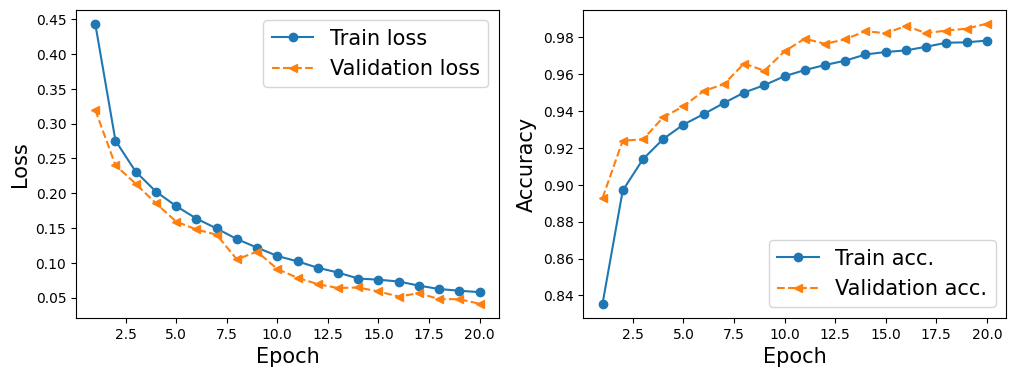

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_2[0], '-o', label='Train loss')
ax.plot(x_arr, hist_2[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_2[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_2[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_model(model_2, test_dl).item()

0.9873999953269958

Wynik jest nieznacznie lepszy.

#### Architektura 3


Architektura z modelu 2 sprawdziła się lepiej niż ta z modelu 1. Sprawdźmy teraz czy zmiana funkcji aktywacji i modyfikacja warstwy liniowej w modelu 2 zmieni wynik.

In [ ]:
import torch.nn as nn

model_3 = nn.Sequential()
model_3.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU1', nn.LeakyReLU())
model_3.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU2', nn.LeakyReLU())
model_3.add_module('dropout1', nn.Dropout(p = 0.3))
model_3.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_3.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU3', nn.LeakyReLU())
model_3.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU4', nn.LeakyReLU())
model_3.add_module('dropout2', nn.Dropout(p=0.3))
model_3.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_3.add_module('flatten', nn.Flatten())
model_3.add_module('fc1', nn.Linear(12544, 512))
model_3.add_module('ReLU5', nn.ReLU())
model_3.add_module('fc2', nn.Linear(512, 10))

In [ ]:
model_3 = model_3.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), weight_decay = 0.05, lr=0.001)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_3 = train(model_3, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8440 val_accuracy: 0.8948
Epoch 2 accuracy: 0.9036 val_accuracy: 0.9224
Epoch 3 accuracy: 0.9177 val_accuracy: 0.9312
Epoch 4 accuracy: 0.9273 val_accuracy: 0.9352
Epoch 5 accuracy: 0.9334 val_accuracy: 0.9438
Epoch 6 accuracy: 0.9380 val_accuracy: 0.9514
Epoch 7 accuracy: 0.9438 val_accuracy: 0.9544
Epoch 8 accuracy: 0.9475 val_accuracy: 0.9569
Epoch 9 accuracy: 0.9509 val_accuracy: 0.9624
Epoch 10 accuracy: 0.9543 val_accuracy: 0.9594
Epoch 11 accuracy: 0.9528 val_accuracy: 0.9300
Epoch 12 accuracy: 0.9528 val_accuracy: 0.9662
Epoch 13 accuracy: 0.9618 val_accuracy: 0.9739
Epoch 14 accuracy: 0.9635 val_accuracy: 0.9710
Epoch 15 accuracy: 0.9650 val_accuracy: 0.9723
Epoch 16 accuracy: 0.9480 val_accuracy: 0.9158
Epoch 17 accuracy: 0.9549 val_accuracy: 0.9507
Epoch 18 accuracy: 0.9663 val_accuracy: 0.9662
Epoch 19 accuracy: 0.9687 val_accuracy: 0.9666
Epoch 20 accuracy: 0.9707 val_accuracy: 0.9815


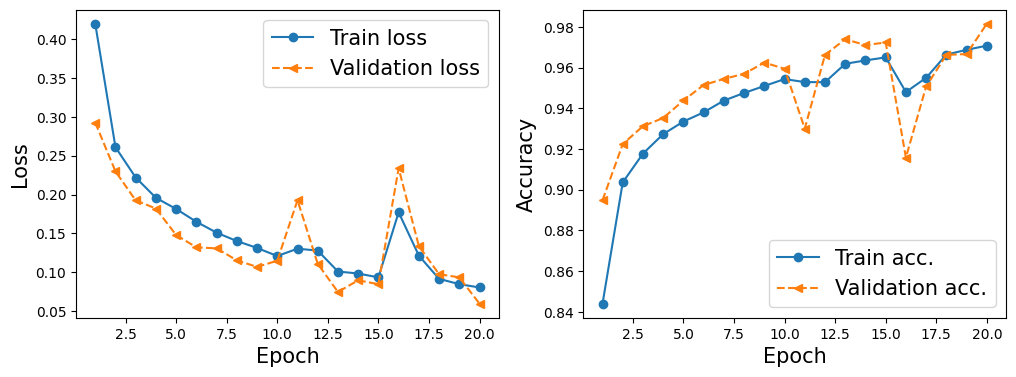

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_3[0], '-o', label='Train loss')
ax.plot(x_arr, hist_3[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_3[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_3[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_model(model_3, test_dl).item()

0.981499969959259

Sprawdźmy model z innym learning rate'm.

In [ ]:
import torch.nn as nn

model_3 = nn.Sequential()
model_3.add_module('conv1', nn.Conv2d(in_channels=1, out_channels=32, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU1', nn.LeakyReLU())
model_3.add_module('conv2', nn.Conv2d(in_channels=32, out_channels=64, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU2', nn.LeakyReLU())
model_3.add_module('dropout1', nn.Dropout(p = 0.3))
model_3.add_module('pool1', nn.MaxPool2d(kernel_size=2))
model_3.add_module('conv3', nn.Conv2d(in_channels=64, out_channels=128, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU3', nn.LeakyReLU())
model_3.add_module('conv4', nn.Conv2d(in_channels=128, out_channels=256, kernel_size=5, padding=2))
model_3.add_module('LeakyReLU4', nn.LeakyReLU())
model_3.add_module('dropout2', nn.Dropout(p=0.3))
model_3.add_module('pool2', nn.MaxPool2d(kernel_size=2))
model_3.add_module('flatten', nn.Flatten())
model_3.add_module('fc1', nn.Linear(12544, 512))
model_3.add_module('ReLU5', nn.ReLU())
model_3.add_module('fc2', nn.Linear(512, 10))

In [ ]:
model_3 = model_3.to(device)

In [ ]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model_3.parameters(), weight_decay = 0.05, lr=0.0005)

In [ ]:
torch.manual_seed(1)

num_epochs = 20
hist_3 = train(model_3, num_epochs, train_dl, valid_dl)

Epoch 1 accuracy: 0.8371 val_accuracy: 0.8907
Epoch 2 accuracy: 0.9002 val_accuracy: 0.9166
Epoch 3 accuracy: 0.9179 val_accuracy: 0.9282
Epoch 4 accuracy: 0.9284 val_accuracy: 0.9398
Epoch 5 accuracy: 0.9359 val_accuracy: 0.9448
Epoch 6 accuracy: 0.9424 val_accuracy: 0.9566
Epoch 7 accuracy: 0.9498 val_accuracy: 0.9610
Epoch 8 accuracy: 0.9547 val_accuracy: 0.9642
Epoch 9 accuracy: 0.9607 val_accuracy: 0.9674
Epoch 10 accuracy: 0.9636 val_accuracy: 0.9748
Epoch 11 accuracy: 0.9676 val_accuracy: 0.9783
Epoch 12 accuracy: 0.9712 val_accuracy: 0.9767
Epoch 13 accuracy: 0.9743 val_accuracy: 0.9803
Epoch 14 accuracy: 0.9768 val_accuracy: 0.9882
Epoch 15 accuracy: 0.9782 val_accuracy: 0.9896
Epoch 16 accuracy: 0.9789 val_accuracy: 0.9896
Epoch 17 accuracy: 0.9806 val_accuracy: 0.9867
Epoch 18 accuracy: 0.9824 val_accuracy: 0.9896
Epoch 19 accuracy: 0.9838 val_accuracy: 0.9928
Epoch 20 accuracy: 0.9854 val_accuracy: 0.9922


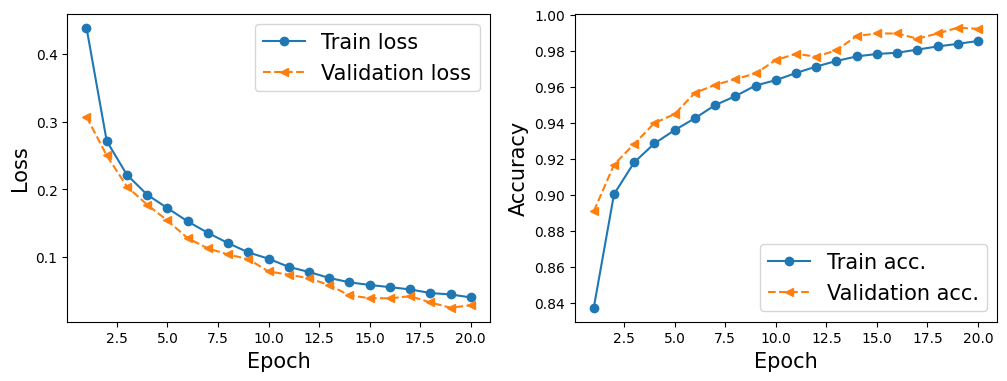

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

x_arr = np.arange(len(hist[0])) + 1

fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_arr, hist_3[0], '-o', label='Train loss')
ax.plot(x_arr, hist_3[1], '--<', label='Validation loss')
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Loss', size=15)
ax.legend(fontsize=15)
ax = fig.add_subplot(1, 2, 2)
ax.plot(x_arr, hist_3[2], '-o', label='Train acc.')
ax.plot(x_arr, hist_3[3], '--<', label='Validation acc.')
ax.legend(fontsize=15)
ax.set_xlabel('Epoch', size=15)
ax.set_ylabel('Accuracy', size=15)

plt.show()

In [ ]:
test_model(model_3, test_dl).item()

0.9921999573707581

Zadowalający wynik.